In [311]:
!pip install sounddevice

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Input, Dropout

# librosa is a Python library for analyzing audio and music.
# It can be used to extract the data from the audio files we will see it later
import librosa
import librosa.display

# to play the audio files
import IPython.display as ipd
from IPython.core.display import display

# to record audio and write it to file
import sounddevice as sd
from scipy.io.wavfile import write

from tqdm.notebook import tqdm

In [2]:
###########################################################################
#WE CREATE THE BIG DATASET FIRST CONTAINING THE FILE PATHS AND THEIR LABELS
###########################################################################

# datasets paths on the machine
CREMA = "data/CREMA-D"
RAVDESS = "data/RAVDESS"
SAVEE = "data/SAVEE"
TESS = "data/TESS"

# paths to saved states
paths_and_labels_state_path = 'states/paths_and_labels.csv'
features_state_path = 'states/data.csv'
checkpoint_path = 'states/models'

# boolean value represents the saved state of the paths and labels
paths_state_saved = True

# boolean value represents the saved state of features
features_state_saved = True

# boolean value represents the saved state of the model
model_state_saved = True

if paths_state_saved:
    paths_df = pd.read_csv(paths_and_labels_state_path)
else:
    paths_df = pd.DataFrame(columns=['gender', 'path', 'emotion'])

In [3]:
# Labels Names
ANGRY = "angry"
DISGUST = "disgust"
FEAR = "fear"
HAPPY = "happy"
NEUTRAL = "neutral"
SAD = "sad"
SURPRISE = "surprise"

In [234]:
# CREMA dataset
CREMA_FILES = os.listdir(CREMA)

female_file_numbers = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

if not paths_state_saved:
    # loop over the files in CREMA dataset, storing their paths, gender and labels
    for index, file in tqdm(enumerate(CREMA_FILES)):
        label = file.split("_")[2]
        file_number = int(file.split("_")[0])

        if label == 'SAD':
            emotion = SAD
        elif label == 'ANG':
            emotion = ANGRY
        elif label == 'DIS':
            emotion = DISGUST
        elif label == 'FEA':
            emotion = FEAR
        elif label == 'HAP':
            emotion = HAPPY
        elif label == 'NEU':
            emotion = NEUTRAL
        else:
            emotion = 'unknown'

        gender = 'female' if file_number in female_file_numbers else 'male'
        path = os.path.join(CREMA, file)

        paths_df.loc[index] = [gender, path, emotion]

paths_df.head()

,Unnamed: 0,gender,path,emotion
0,0,male,data/CREMA-D\1001_DFA_ANG_XX.wav,angry
1,1,male,data/CREMA-D\1001_DFA_DIS_XX.wav,disgust
2,2,male,data/CREMA-D\1001_DFA_FEA_XX.wav,fear
3,3,male,data/CREMA-D\1001_DFA_HAP_XX.wav,happy
4,4,male,data/CREMA-D\1001_DFA_NEU_XX.wav,neutral


In [235]:
# RAVDESS dataset

# adjust the index
index += 1
if not paths_state_saved:
    for dirname, _, filenames in tqdm(os.walk(RAVDESS)):
        for filename in filenames:
            # filename contains set of labels in the following form: 03-01-01-01-01-01-01.wav
            # naming conventions can be found in this link: https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio

            label = filename.split('-')[2]
            if label == '01':
                emotion = NEUTRAL
            elif label == '02':
                continue # not found in others
            elif label == '03':
                emotion = HAPPY
            elif label == '04':
                emotion = SAD
            elif label == '05':
                emotion = ANGRY
            elif label == '06':
                emotion = FEAR
            elif label == '07':
                emotion = DISGUST
            elif label == '08':
                emotion = SURPRISE
            else:
                emotion = 'unknown'

            actor_number = int(filename.split('-')[-1][:2])
            gender = 'female' if actor_number % 2 == 0 else 'male'

            path = os.path.join(dirname, filename)

            paths_df.loc[index] = [gender, path, emotion]
            index += 1

In [236]:
# SAVEE dataset
if not paths_state_saved:
    SAVEE_FILES = os.listdir(SAVEE)
    for savee_index, file in tqdm(enumerate(SAVEE_FILES)):

        if file[-7] == 'a':
            emotion = ANGRY
        elif file[-7] == 'd':
            emotion = DISGUST
        elif file[-7] == 'f':
            emotion = FEAR
        elif file[-7] == 'h':
            emotion = HAPPY
        elif file[-7] == 'n':
            emotion = NEUTRAL
        elif file[-8: -6] == 'sa':
            emotion = SAD
        elif file[-8: -6] == 'su':
            emotion = SURPRISE
        else:
            emotion = 'unknown'

        gender = 'male'
        path = os.path.join(SAVEE, file)

        paths_df.loc[index + savee_index] = [gender, path, emotion]

In [237]:
# TESS dataset

if not paths_state_saved:
    # adjust the index
    index += savee_index + 1

    TESS_FILES = os.listdir(TESS)
    for dirname, _, filenames in tqdm(os.walk(TESS)):
        for filename in filenames:
            label = filename.split('.')[0].split('_')[-1]

            if label == 'neutral':
                emotion = NEUTRAL
            elif label == 'happy':
                emotion = HAPPY
            elif label == 'sad':
                emotion = SAD
            elif label == 'angry':
                emotion = ANGRY
            elif label == 'fear':
                emotion = FEAR
            elif label == 'disgust':
                emotion = DISGUST
            elif label == 'ps':
                emotion = SURPRISE
            else:
                emotion = 'unknown'

            gender = 'female'
            path = os.path.join(dirname, filename)

            paths_df.loc[index] = [gender, path, emotion]
            index += 1

In [4]:
# Save the results or load them if saved
if not paths_state_saved:
    paths_df.to_csv(paths_and_labels_state_path)
    paths_state_saved = True
else:
    paths_df = pd.read_csv(paths_and_labels_state_path)

# The final datasets of the gender, path, and emotion of audio files from 4 combined datasets
paths_df

,Unnamed: 0,gender,path,emotion
0,0,male,data/CREMA-D\1001_DFA_ANG_XX.wav,angry
1,1,male,data/CREMA-D\1001_DFA_DIS_XX.wav,disgust
2,2,male,data/CREMA-D\1001_DFA_FEA_XX.wav,fear
3,3,male,data/CREMA-D\1001_DFA_HAP_XX.wav,happy
4,4,male,data/CREMA-D\1001_DFA_NEU_XX.wav,neutral
...,...,...,...,...
11965,11966,female,data/TESS\YAF_sad\YAF_witch_sad.wav,sad
11966,11967,female,data/TESS\YAF_sad\YAF_yearn_sad.wav,sad
11967,11968,female,data/TESS\YAF_sad\YAF_yes_sad.wav,sad
11968,11969,female,data/TESS\YAF_sad\YAF_young_sad.wav,sad


E:\Applications\Programs\Anaconda3\envs\newenvt\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


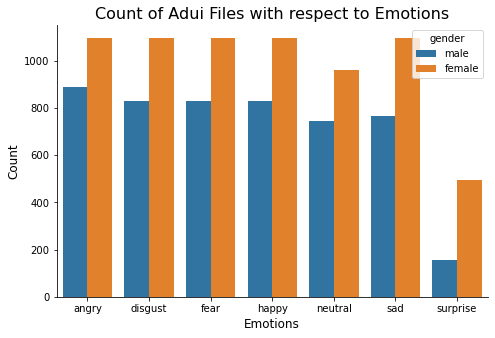

In [5]:
###################
#DATA VISUALIZATION
###################
order = [ANGRY, DISGUST, FEAR, HAPPY, NEUTRAL, SAD, SURPRISE]

fig = plt.figure(figsize=(17, 5))

fig.add_subplot(121)
plt.title('Count of Adui Files with respect to Emotions', size=16)
sns.countplot(paths_df.emotion, order = order, hue=paths_df.gender)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

plt.show()

In [6]:
def create_waveplot(path, label, activation = lambda x: x):
    data, sampling_rate = librosa.load(path)
    
    data = activation(data)
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {label} emotion', size=15)
    librosa.display.waveplot(data, sr=sampling_rate)
    plt.show()
    
    display(ipd.Audio(path))

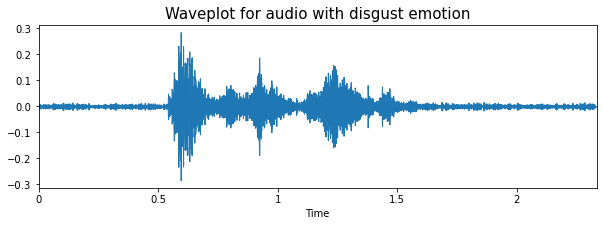

In [7]:
audio = paths_df.loc[1]
create_waveplot(audio['path'], audio['emotion'])

In [8]:
##################
#DATA AUGMENTATION
##################

def noise(data):
    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.70):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.8):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def higher_speed(data, speed_factor = 1.25):
    return librosa.effects.time_stretch(data, speed_factor)

def lower_speed(data, speed_factor = 0.75):
    return librosa.effects.time_stretch(data, speed_factor)

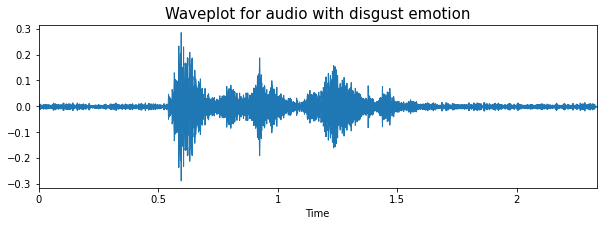

In [9]:
audio = paths_df.loc[1]
create_waveplot(audio['path'], audio['emotion'], activation=noise)

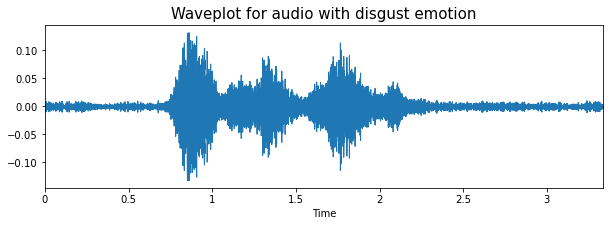

In [10]:
audio = paths_df.loc[1]
create_waveplot(audio['path'], audio['emotion'], activation=stretch)

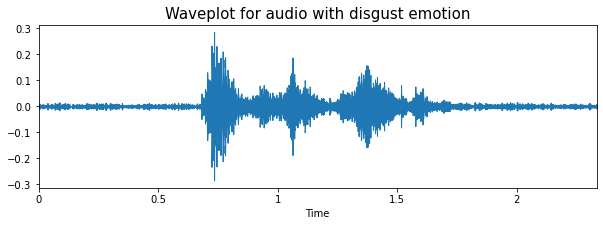

In [11]:
audio = paths_df.loc[1]
create_waveplot(audio['path'], audio['emotion'], activation=shift)

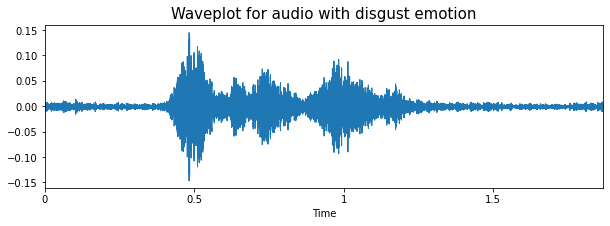

In [12]:
audio = paths_df.loc[1]
create_waveplot(audio['path'], audio['emotion'], activation=higher_speed)

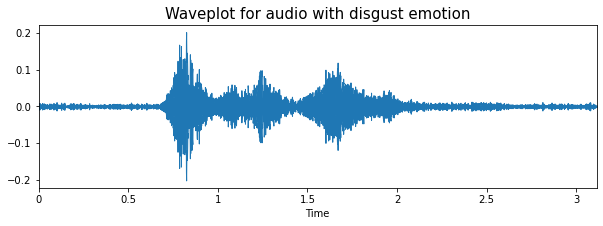

In [13]:
audio = paths_df.loc[1]
create_waveplot(audio['path'], audio['emotion'], activation=lower_speed)

In [14]:
################################################################
#FEATURE EXTRACTION (Mel Frequency Cepstral Coefficents (MFCCs))
################################################################
#sample_rate = 22050

def extract_features(data):
    
    result = np.array([])
    
    mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    result = np.array(mfccs_processed)
     
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=3, offset=0.5, res_type='kaiser_fast') 
    
    #without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    #noised
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    #stretched
    stretch_data = stretch(data)
    res3 = extract_features(stretch_data)
    result = np.vstack((result, res3))
    
    #shifted
    shift_data = shift(data)
    res4 = extract_features(shift_data)
    result = np.vstack((result, res4))
    
    #pitched
    pitch_data = pitch(data, sample_rate)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5)) 
    
    #speed up
    higher_speed_data = higher_speed(data)
    res6 = extract_features(higher_speed_data)
    result = np.vstack((result, res6))
    
    #speed down
    lower_speed_data = higher_speed(data)
    res7 = extract_features(lower_speed_data)
    result = np.vstack((result, res7))
    
    return result

In [250]:
if not features_state_saved:
    X, Y = [], []
    for path, emotion in tqdm(zip(paths_df.path, paths_df.emotion)):
        features = get_features(path)
        #adding augmentation, get_features return a multi dimensional array (for each augmentation), so we have to use a loop to fill the df
        for elem in features: 
            X.append(elem)        
            Y.append(emotion)
    
    print(f'Check shapes:\nFeatures: {len(X)}, labels: {len(Y)}\n')

In [15]:
if not features_state_saved:
    genders = []
    for i in paths_df['gender']:
        genders.extend([i]*7)
    
    df = pd.DataFrame(X)
    df['gender'] = genders
    df['labels'] = Y
    
    df.to_csv(features_state_path)
    features_state_saved = True
else:
    df = pd.read_csv(features_state_path)

In [16]:
df

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,gender,labels
0,0,-329.505432,136.153870,-25.280516,48.723938,-7.727358,13.914086,-19.400671,-9.626479,-4.519334,...,-0.095054,-0.986772,1.528102,0.838687,0.658742,1.083820,-0.625087,-1.305139,male,angry
1,1,-308.324150,112.561089,-10.845607,38.337810,0.753702,7.006222,-14.493548,-11.693682,-4.803154,...,-0.286558,-0.811399,1.171431,1.238270,0.561103,0.966728,-0.590618,-1.250609,male,angry
2,2,-358.429932,126.205223,-20.705435,43.439529,-4.393497,9.943935,-17.811848,-10.847023,-4.317072,...,0.056860,-0.561635,0.826081,0.815856,0.053674,0.955412,-0.568858,-0.548624,male,angry
3,3,-325.422760,136.360123,-25.696379,48.095085,-8.804231,12.848850,-19.255320,-9.299890,-4.432343,...,-0.008876,-1.118659,1.668538,1.145730,0.691445,1.174603,-0.752062,-1.369604,male,angry
4,4,-348.986481,123.735909,-18.248728,43.267925,-7.746000,7.509576,-21.403446,-7.419728,-5.251650,...,0.129413,1.047413,0.429171,-1.546443,-1.001225,-2.593983,-0.072818,1.519294,male,angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83785,83785,-460.957916,74.498482,26.838991,51.369102,0.388139,16.159008,-5.462575,-7.904902,-1.993220,...,4.619484,1.825554,-0.819392,-2.834429,-0.069078,-0.467367,-2.668103,-1.976927,female,sad
83786,83786,-421.927612,80.721237,26.293892,53.028133,-2.365307,16.700602,-5.469858,-6.419626,-3.181014,...,4.367050,1.928765,-0.710847,-3.003551,-0.244896,-0.929307,-2.386013,-1.976752,female,sad
83787,83787,-457.291992,73.174126,30.681774,49.348705,-1.001292,14.311184,-8.077559,-7.485866,0.352114,...,-2.047189,-3.989159,-2.603652,0.751622,-1.114644,-4.037850,-1.411363,-0.869048,female,sad
83788,83788,-453.760345,78.377571,27.320187,52.938007,-0.100548,16.946051,-6.199852,-7.345070,-1.944296,...,4.422561,2.134478,-0.750485,-3.499669,0.288149,-0.584265,-2.639793,-1.973065,female,sad


In [17]:
df = df.drop(['gender', 'Unnamed: 0'], axis=1)

In [18]:
df

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,labels
0,-329.505432,136.153870,-25.280516,48.723938,-7.727358,13.914086,-19.400671,-9.626479,-4.519334,-8.450821,...,0.197650,-0.095054,-0.986772,1.528102,0.838687,0.658742,1.083820,-0.625087,-1.305139,angry
1,-308.324150,112.561089,-10.845607,38.337810,0.753702,7.006222,-14.493548,-11.693682,-4.803154,-7.133898,...,0.251861,-0.286558,-0.811399,1.171431,1.238270,0.561103,0.966728,-0.590618,-1.250609,angry
2,-358.429932,126.205223,-20.705435,43.439529,-4.393497,9.943935,-17.811848,-10.847023,-4.317072,-7.680136,...,0.187333,0.056860,-0.561635,0.826081,0.815856,0.053674,0.955412,-0.568858,-0.548624,angry
3,-325.422760,136.360123,-25.696379,48.095085,-8.804231,12.848850,-19.255320,-9.299890,-4.432343,-8.448897,...,0.356289,-0.008876,-1.118659,1.668538,1.145730,0.691445,1.174603,-0.752062,-1.369604,angry
4,-348.986481,123.735909,-18.248728,43.267925,-7.746000,7.509576,-21.403446,-7.419728,-5.251650,-7.024423,...,0.566898,0.129413,1.047413,0.429171,-1.546443,-1.001225,-2.593983,-0.072818,1.519294,angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83785,-460.957916,74.498482,26.838991,51.369102,0.388139,16.159008,-5.462575,-7.904902,-1.993220,-6.021053,...,1.710504,4.619484,1.825554,-0.819392,-2.834429,-0.069078,-0.467367,-2.668103,-1.976927,sad
83786,-421.927612,80.721237,26.293892,53.028133,-2.365307,16.700602,-5.469858,-6.419626,-3.181014,-4.789697,...,1.839488,4.367050,1.928765,-0.710847,-3.003551,-0.244896,-0.929307,-2.386013,-1.976752,sad
83787,-457.291992,73.174126,30.681774,49.348705,-1.001292,14.311184,-8.077559,-7.485866,0.352114,-8.687172,...,4.072392,-2.047189,-3.989159,-2.603652,0.751622,-1.114644,-4.037850,-1.411363,-0.869048,sad
83788,-453.760345,78.377571,27.320187,52.938007,-0.100548,16.946051,-6.199852,-7.345070,-1.944296,-6.337290,...,1.872562,4.422561,2.134478,-0.750485,-3.499669,0.288149,-0.584265,-2.639793,-1.973065,sad


In [19]:
# split the data: 80% train and 10% validation 10% test
X_train, X_test, y_train, y_test = train_test_split(df.drop(['labels'], axis=1),
                                                   df['labels'],
                                                   test_size=0.2,
                                                   shuffle=True,
                                                   random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                               test_size=0.5,
                                               shuffle=True,
                                               random_state=42)

X_train[:10]

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
29053,-451.528870,163.929825,-6.144918,73.053329,-19.743292,34.366848,-13.610373,6.172061,-5.499417,-5.406612,...,0.695541,-1.843405,-1.424150,-1.636501,0.527948,0.102322,-1.179254,-0.039791,0.514208,1.052676
42931,-397.078094,146.469238,-8.657708,59.649483,-14.848886,12.116788,-11.835086,5.399646,-3.976837,-7.549291,...,-3.805275,-2.948309,0.106724,1.273202,0.068725,0.121858,-1.479408,-0.304388,-0.124338,0.825108
11587,-425.147552,129.472137,5.249687,58.841763,-13.591125,12.827356,-8.474058,2.389023,-4.827617,-4.615673,...,0.870105,0.319361,2.435358,2.746389,-0.093086,-1.035378,0.966398,1.337419,-0.342763,-0.322247
55005,-560.509399,61.607735,-6.094296,9.040191,-8.759007,4.444358,-7.184345,-18.630058,-15.789490,-1.593970,...,1.016282,1.421041,0.638071,-0.364061,-0.463851,-0.445836,0.977480,1.365148,1.316395,2.037565
23121,-392.332306,164.187332,4.270962,44.415741,-24.076511,15.177536,-7.175929,-1.348743,-5.048977,-11.605805,...,-4.427649,-2.669489,-0.577273,4.258329,5.445980,5.800240,2.923477,1.069079,0.262979,0.679349
29334,-470.539337,142.324448,13.787644,59.633877,-12.740906,17.593660,-10.003701,1.993399,-7.940176,-5.055899,...,-0.411227,-1.778095,-0.273375,-1.362729,-0.002881,0.654670,-0.338168,-1.428703,0.268627,2.124011
59438,-368.490779,53.057296,-16.336040,12.044013,4.415752,-10.632605,-6.963352,-3.524023,-19.648107,-1.455022,...,-0.336080,-0.440610,-0.564935,-0.190373,0.943858,0.393786,0.483423,-0.161784,0.207858,0.060338
67465,-458.908447,97.901649,-5.221488,-31.931849,-11.185575,14.733130,-20.323309,0.355853,-20.934738,0.024344,...,7.791245,2.871248,-0.712700,3.441112,6.377660,-0.114173,5.132684,2.124687,-1.556447,0.939194
7678,-351.256256,142.696701,-14.963496,40.967937,-17.361290,-2.795644,2.328927,-0.316483,-11.454165,-4.383756,...,-2.392172,-0.096478,3.086920,1.834174,-0.127144,-0.850141,-0.463219,1.291746,2.391165,-0.706748
50888,-402.002686,102.131699,-19.355053,65.986290,-24.489357,32.225670,-23.469210,10.715014,-7.638764,-0.983023,...,-1.622299,-0.957026,1.049242,-0.836037,-1.772830,-2.599925,-1.160122,-2.224225,-0.402916,-1.012002


In [20]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(67032, 58)
(8379, 58)
(8379, 58)


In [21]:
# Normalizing the values
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_val = (X_val - mean)/std
X_test = (X_test - mean)/std

X_train[:10]

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
29053,-0.458559,1.255319,-0.240337,1.567256,-0.698625,1.904675,-0.305103,1.167243,0.374045,-0.440329,...,0.163129,-0.795870,-0.812118,-0.849666,0.132808,-0.094184,-0.685386,-0.136097,0.184371,0.407195
42931,0.079322,0.834520,-0.379261,1.011836,-0.314757,0.138574,-0.073384,1.062430,0.581987,-0.826953,...,-1.535587,-1.244059,-0.150576,0.509476,-0.101058,-0.084300,-0.849616,-0.278140,-0.163067,0.281309
11587,-0.197956,0.424892,0.389634,0.978367,-0.216111,0.194976,0.365313,0.653905,0.465794,-0.297612,...,0.229013,0.081427,0.855705,1.197612,-0.183463,-0.669738,0.488612,0.603227,-0.281914,-0.353385
55005,-1.535101,-1.210633,-0.237538,-1.085277,0.162872,-0.470425,0.533652,-2.198274,-1.031292,0.247622,...,0.284184,0.528308,0.079037,-0.255300,-0.372281,-0.371493,0.494675,0.618112,0.620846,0.952016
23121,0.126202,1.261525,0.335523,0.380591,-1.038480,0.381522,0.534751,0.146709,0.435562,-1.558908,...,-1.770486,-1.130959,-0.446154,1.903849,2.637393,2.788354,1.559431,0.459175,0.047675,0.200678
29334,-0.646350,0.734631,0.861669,1.011190,-0.149428,0.573302,0.165657,0.600221,0.040705,-0.377046,...,-0.254592,-0.769377,-0.314829,-0.721785,-0.137525,0.185246,-0.225185,-0.881703,0.050748,0.999836
59438,0.361716,-1.416698,-0.803771,-0.960807,1.196169,-1.667161,0.562497,-0.148465,-1.558272,0.272694,...,-0.226230,-0.226845,-0.440822,-0.174169,0.344617,0.053266,0.224351,-0.201586,0.017683,-0.141747
67465,-0.531456,-0.335954,-0.189283,-2.783049,-0.027444,0.346247,-1.181308,0.378014,-1.733990,0.539630,...,2.841217,1.116564,-0.504676,1.522122,3.111866,-0.203707,2.768204,1.025854,-0.942288,0.344419
7678,0.531964,0.743603,-0.727887,0.237723,-0.511805,-1.045101,1.775370,0.286782,-0.439208,-0.255765,...,-1.002248,-0.087253,1.137267,0.771510,-0.200808,-0.576028,-0.293606,0.578708,1.205636,-0.566084
50888,0.030676,-0.234010,-0.970682,1.274417,-1.070859,1.734719,-1.591926,1.783698,0.081870,0.357861,...,-0.711680,-0.436322,0.256718,-0.475763,-1.038899,-1.461231,-0.674918,-1.308761,-0.314643,-0.734944


In [22]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [23]:
# mapping the labels into numbers: angry -> 0, disgust -> 1, etc.
encoder = LabelEncoder()
encoder.fit(y_train)

# encoding the mapped values into vectors (one hot encoding), e.g.:
# 0 -> [1, 0, 0, 0, 0, 0, 0]
# 1 -> [0, 1, 0, 0, 0, 0, 0]
# 5 -> [0, 0, 0, 0, 0, 1, 0]
y_train_encoded = tf.keras.utils.to_categorical(encoder.transform(y_train))
y_val_encoded = tf.keras.utils.to_categorical(encoder.transform(y_val))
y_test_encoded = tf.keras.utils.to_categorical(encoder.transform(y_test))

print(encoder.classes_)
print(y_test)
print(y_test_encoded)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
['surprise' 'angry' 'angry' ... 'fear' 'fear' 'sad']
[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [24]:
##################################
#Defining plotting curves function 
##################################

def plot_curve(epochs, hist, list_of_metrics, title):
    """Plot a curve of one or more classification metrics vs. epoch."""  

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()
    plt.title(title)

In [25]:
###################
#BUILDING THE MODEL
###################

model = tf.keras.Sequential([
    Input(X_train.shape[1]),
    Dense(units=256, activation ='relu'),
    Dropout(0.1),
    Dense(units=128, activation ='relu'),
    Dropout(0.1),
    Dense(units=64, activation ='relu'),
    Dropout(0.1),
    Dense(units=32, activation ='relu'),
    Dropout(0.1),
    Dense(units=7, activation ='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               15104     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

In [26]:
opt = tf.keras.optimizers.RMSprop(lr=0.001, decay=1e-6,momentum=0.5)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_path = os.path.join(checkpoint_path, 'model_1/cp.ckpt')

if model_state_saved:
    model.load_weights(model_path)
else:
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    history = model.fit(X_train, y_train_encoded, 
                        batch_size=256, epochs=100, 
                        validation_data=(X_test, y_test_encoded),
                        callbacks=[cp_callback])

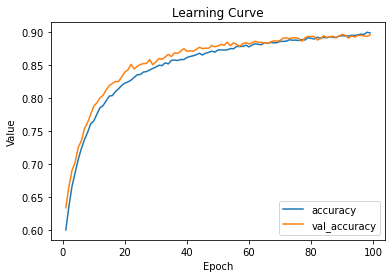

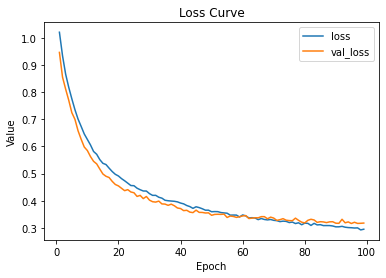

In [437]:
if not model_state_saved:
    hist = history.history
    epochs = history.epoch
    
    learning_metrics = ['accuracy', 'val_accuracy']
    loss_metrics = ['loss', 'val_loss']
    
    plot_curve(epochs, hist, learning_metrics, "Learning Curve")
    plot_curve(epochs, hist, loss_metrics, "Loss Curve")
    
    model_state_saved = True

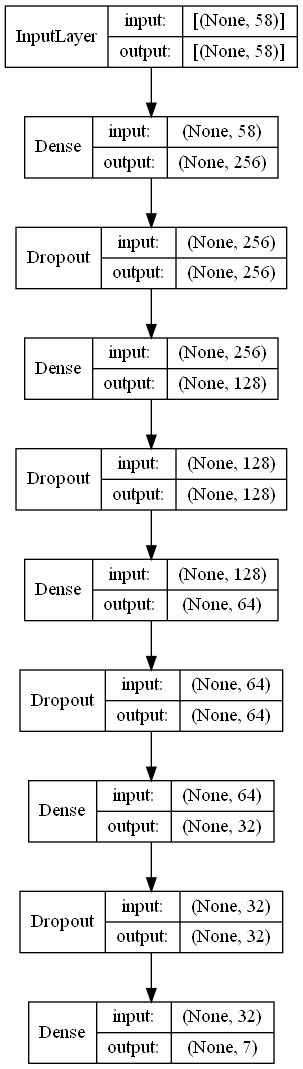

In [446]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=False, rankdir='TB', expand_nested=False, dpi=96
)

In [27]:
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Loss: {:.2f}\nAccuracy:{:.2f}%".format(loss, accuracy*100))

262/262 [==============================] - 3s 4ms/step - loss: 0.3097 - accuracy: 0.8955
Loss: 0.32
Accuracy:89.55%


In [99]:
def record_audio():
    fs = 22050  # Sample rate
    seconds = 3  # Duration of recording

    print("Recording")
    myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
    sd.wait()  # Wait until recording is finished
    print("Done recording")
    write('test.wav', fs, myrecording)  # Save as WAV file 

def test_audio(path, actual_label = None):    
    data, sample_rate = librosa.load(path, res_type='kaiser_fast') # duration=3, offset=0.5,
    features = extract_features(data)
    mfccs = np.array(features)
    mfccs = (mfccs - mean)/std
    mfccs = np.array(mfccs)
    mfccs = np.expand_dims(mfccs, axis=0)
    
    y_pred = model.predict(mfccs)
    predicted_label_index = np.argmax(y_pred)
    predicted_label = encoder.inverse_transform([predicted_label_index])
    print("Predicted Label: " + predicted_label[0])
    
    if actual_label != None:
        print("Actual Label: " + actual_label)
        
def test_audio_with_augmentation(path, actual_label = None):
    mfccs = get_features(path)
    
    result = np.zeros(shape=(1,7))
    for row in mfccs:
        row = (row - mean)/std
        row = np.expand_dims(row, axis=0)
        y_pred = model.predict_on_batch(row)
        
        result += y_pred
            
    predicted_label_index = np.argmax(result)
    predicted_label = encoder.inverse_transform([predicted_label_index])
        
    print("With Augmentation: predicted Label: " + predicted_label[0])
    
    if actual_label != None:
        print("Actual Label: " + actual_label)

def live_test():
    record_audio()
    print("\n\nProcessing...")
    test_audio('test.wav')
    print("With Augmentation:", end=" ")
    test_audio_with_augmentation('test.wav')

In [95]:
for i in range(10):
    index = np.random.randint(0, len(paths_df))
    audio = paths_df.loc[index]
    display(ipd.Audio(audio['path']))
    test_audio(audio['path'], audio['emotion'])
    print("With Augmentation:", end=" ")
    test_audio_with_augmentation(audio['path'])
    print()

Predicted Label: disgust
Actual Label: disgust
Using Augmentation: Predicted Label: disgust



Predicted Label: disgust
Actual Label: disgust
Using Augmentation: Predicted Label: disgust



Predicted Label: neutral
Actual Label: neutral
Using Augmentation: Predicted Label: neutral



Predicted Label: disgust
Actual Label: disgust
Using Augmentation: Predicted Label: disgust



Predicted Label: fear
Actual Label: fear
Using Augmentation: Predicted Label: fear



Predicted Label: happy
Actual Label: happy
Using Augmentation: Predicted Label: happy



Predicted Label: fear
Actual Label: fear
Using Augmentation: Predicted Label: fear



Predicted Label: neutral
Actual Label: neutral
Using Augmentation: Predicted Label: neutral



Predicted Label: angry
Actual Label: happy
Using Augmentation: Predicted Label: happy



Predicted Label: neutral
Actual Label: neutral
Using Augmentation: Predicted Label: neutral



In [109]:
live_test()

Recording
Done recording


Processing...
Predicted Label: happy
With Augmentation: Predicted Label: happy
